In [39]:
from fdfdpy import Simulation

import sys
sys.path.append("..")

from optimization import Optimization
from structures import two_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# fundamental constants and simulation parameters
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.4e-1                   # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 20              # amplitude of modal source (A/L0^2?)

In [41]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 6e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [42]:
# geometric parameters
L = 10         # length of design region (L0)
H = 4         # height of design region (L0)
w = 0.5        # width of waveguides (L0)
l = 4         # length of waveguide from PML to design region (L0)
spc = 1     # space between box and PML (L0)

Computed a domain with 480 grids in x and 180 grids in y
The simulation has 50 grids per free space wavelength


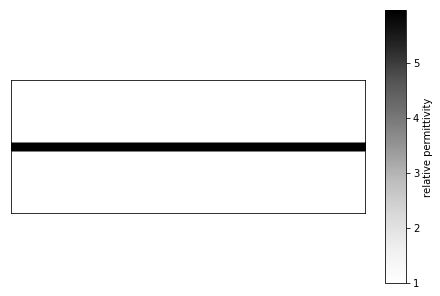

In [43]:
# define permittivity of two port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega, eps_r, dl, NPML, pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [59]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=source_amp)
simulation.setup_modes()
print('Calculate an input power of {} Watts/L0'.format(simulation.W_in))

# out modal profile
sim_out = Simulation(omega, eps_r, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)

# in modal profile
sim_in = Simulation(omega, eps_r, dl, NPML, 'Ez')
sim_in.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l*2/3/dl), ny], int(Ny/2))
sim_in.setup_modes()
J_in = np.abs(sim_in.src)

Calculate an input power of 0.563590625649391 Watts/L0


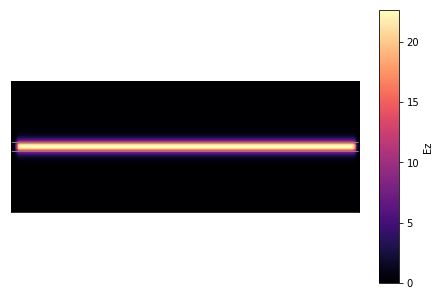

In [60]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [61]:
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
import copy
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

### First let's try to make a cavity

In [62]:
Jcent = np.zeros(eps_r.shape)
Jcent[nx, ny] = 1
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*Jcent)
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*Jcent

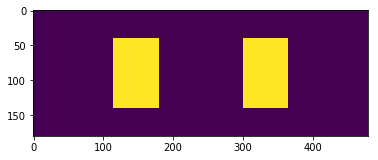

In [63]:
des_cavity1 = copy.deepcopy(design_region)
des_cavity1[180:301, :] = 0
plt.imshow(des_cavity1.T)
plt.show()

100% (2500 of 2500) |####################| Elapsed Time: 0:38:34 ETA:  00:00:00

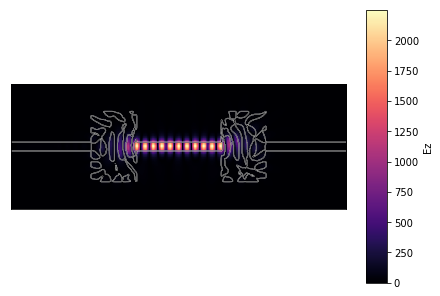

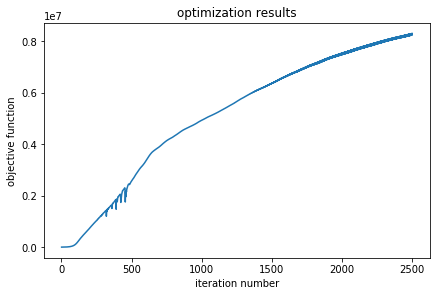

In [64]:
# optimization parameters
Nsteps = 2500
step_size = 0.5e-1
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_r
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)
# run the optimization with the simulation and the region and nonlinearity information
eps_cav1 = optimization.run(simulation, des_cavity1)
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
optimization.plt_objs(scaled='W_in')
plt.show()

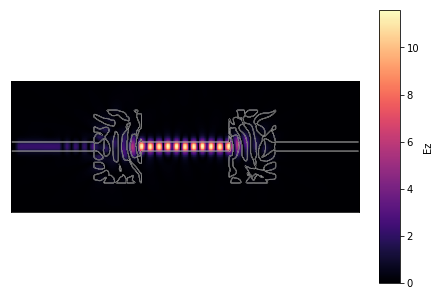

In [109]:
simulation.eps_r = eps_cav1
simulation.modes= []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=1)
simulation.setup_modes()
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)
(Hx,Hy,Ez,_) = simulation.solve_fields_nl()
simulation.plt_abs(outline=True, cbar=True);

In [110]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.W_in

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.W_in

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))

difference of 97.27775391499374 %
linear transmission    = 0.09418960440513216
nonlinear transmission = 0.0025640728184016023
difference of 9.162553158673056 %


N/A% (0 of 20000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

4.6153362897610095e-09 5.021538740379583e-09 0.08801145249582831
1.4861009784471269e-08 1.4893086763834162e-08 0.002158465664723005
-1.9331900254167225e-05 -1.9331894418606055e-05 3.01861746321474e-07
1.054186756690097e-05 1.0541851003242897e-05 1.5712261578303286e-06
-2.421134072496118e-08 -2.4196478154436818e-08 0.0006138681328390321


100% (20000 of 20000) |##################| Elapsed Time: 5:17:13 ETA:  00:00:00

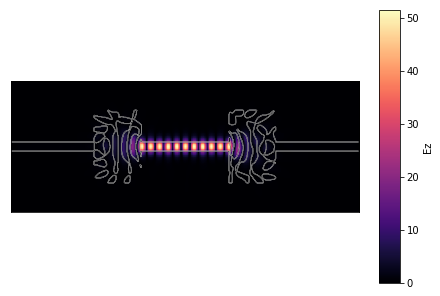

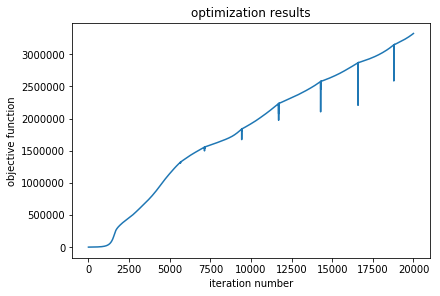

In [126]:
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*J_out)*np.sum(np.square(np.abs(e))*Jcent)
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*J_out*np.sum(np.square(np.abs(e))*Jcent) + \
                                         np.conj(e)*Jcent*np.sum(np.square(np.abs(e))*J_out)   

# optimization parameters
Nsteps = 20000
step_size = 0.02e-1
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_r
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)
(avm_grads, num_grads) = optimization.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))
# run the optimization with the simulation and the region and nonlinearity information
eps_cav2 = optimization.run(simulation, des_cavity1)
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
optimization.plt_objs(scaled='W_in')
plt.show()

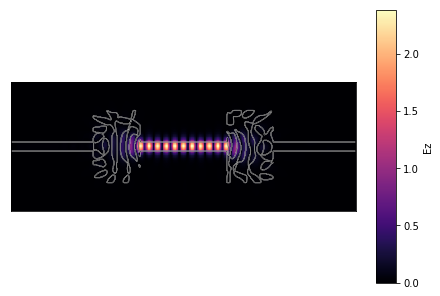

8.578467780149083e-08 8.57858315633786e-08 1.3449510067941903e-05
-7.493930264286146e-07 -7.494609099989447e-07 9.058473716192787e-05
-1.187799098891982e-08 -1.2082353346987151e-08 0.017205128229004933
-2.625009263497431e-07 -2.625417157980925e-07 0.00015538782630833444
-4.469593655285223e-07 -4.46832995951163e-07 0.0002827316913023586
difference of 14.401456538821371 %
linear transmission    = 0.5411858030290213
nonlinear transmission = 0.46324716481152534
difference of 7.793863821749597 %
8.806103525771714e-07 4.7657382081514605e-07 8.806103525771714e-07 4.0794024913505235e-07


In [144]:
simulation.eps_r = eps_cav2
simulation.modes= []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=0.025)
simulation.setup_modes()
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))
W_in_lin = simulation.W_in

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))
W_in_nl = simulation.W_in
simulation.plt_abs(outline=True, cbar=True)
plt.show()
(avm_grads, num_grads) = optimization.check_deriv_lin(simulation, des_cavity1)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))
print(W_in_lin, W_out_lin, W_in_nl, W_out_nl)

In [90]:
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*J_out)
J['nonlinear'] = lambda e, eps_r:  -np.sum(np.square(np.abs(e))*J_out)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*J_out
dJ['dE_nonlinear'] = lambda e, eps_r:  -np.conj(e)*J_out
# dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_out
# dJ['dE_nonlinear'] = lambda e, eps_r: -np.conj(e)*J_out
dJ['total']        = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin
print(J['linear'](Ez, eps_cav1), J['nonlinear'](Ez_nl, eps_cav1))

1.635329728593674 -0.04745911126554372


In [116]:
# optimization parameters
Nsteps =  200
step_size = 1e-4
solver = 'newton'
opt_method = 'adam'

design_region1 = copy.deepcopy(design_region)
design_region1[0:100, :] = 0
design_region1[211:, :] = 0

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_cav2
simulation.modes = []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=1)
simulation.setup_modes()
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)

# check the derivatives
# (grad_avm, grad_num) = optimization.check_deriv_lin(simulation, design_region)
# print('differences: = \n{}'.format([abs(a - n)/abs(a) for a, n in zip(grad_avm, grad_num)]))
# print(grad_avm)
# (grad_avm, grad_num) = optimization.check_deriv_nonlin(simulation, design_region)
# print('differences: = \n{}'.format([abs(a - n)/abs(a) for a, n in zip(grad_avm, grad_num)]))
# print(grad_avm)


In [117]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, design_region)

100% (200 of 200) |######################| Elapsed Time: 0:33:13 ETA:  00:00:00

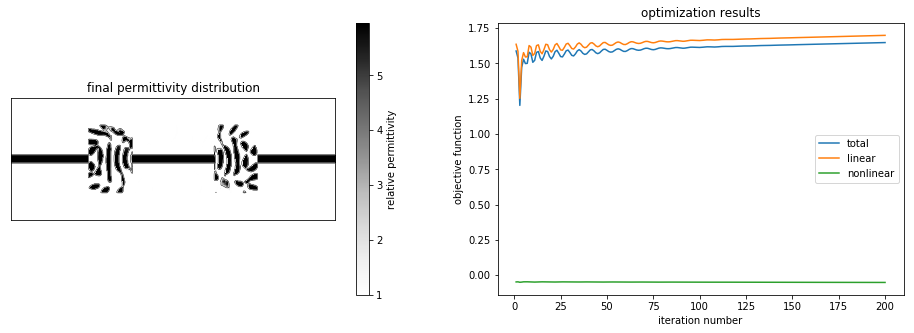

[1.5878706173269614, 1.5380608559192988, 1.2025955553520773, 1.4719408129944236, 1.5295469263278902, 1.4988041431084569, 1.500204718544831, 1.579035691751449, 1.5672291172950705, 1.507720610972517, 1.521538864209158, 1.577800206020749, 1.5840910957897054, 1.5382617941136558, 1.5209642803380161, 1.5504296572074523, 1.5878374134755944, 1.5840839324179563, 1.54905774476096, 1.531588293228152, 1.5500440047333357, 1.5826162827023373, 1.5931270058939802, 1.5719093467066205, 1.5481473425788095, 1.5459511285997674, 1.5656728992981934, 1.5893512092533981, 1.5942712637932512, 1.577095875448254, 1.5569297980980916, 1.552780880369659, 1.5674313708185885, 1.5881864628483262, 1.5972454314999915, 1.5876832687656235, 1.5712839053278922, 1.563511718738244, 1.5673408750453273, 1.5817962725368486, 1.5957185211709752, 1.5984395107155713, 1.5886474463042077, 1.5752420351919807, 1.5690319076056576, 1.574460337295733, 1.5874857042824262, 1.598766161187142, 1.6003200591561706, 1.59237074441094, 1.583476857764

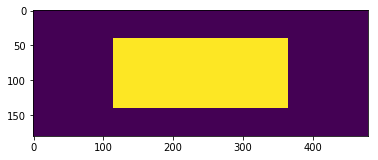

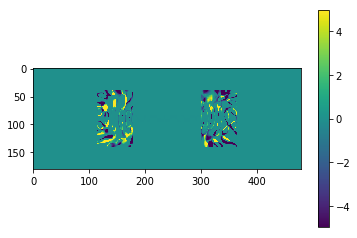

In [118]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# ax1.plot(optimization.W_in)
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, scaled='1W_in')
# ax2.set_yscale('log')
plt.show()
print(optimization.objs_tot)
plt.imshow(design_region.T)
plt.show()
plt.imshow((new_eps - eps_cav1).T)
plt.colorbar()
plt.show()

In [157]:
Jcent = np.zeros(eps_r.shape)
Jcent[nx, ny] = 1
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*Jcent)
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*Jcent

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_cav1
simulation.modes = []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=0.5)
simulation.setup_modes()
optimization = Optimization(Nsteps=100, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)

# run the optimization with the simulation and the region and nonlinearity information
eps_cav2 = optimization.run(simulation, design_region1)

100% (100 of 100) |######################| Elapsed Time: 0:00:45 ETA:  00:00:00

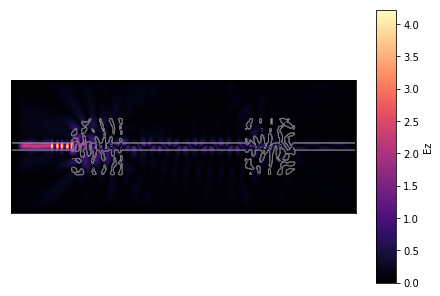

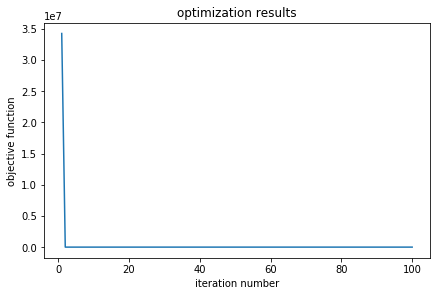

In [158]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
optimization.plt_objs(scaled='W_in')
plt.show()

In [119]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))

difference of 96.70260763105472 %
linear transmission    = 0.5965523727241456
nonlinear transmission = 0.18234091784921394
difference of 41.42114548749317 %


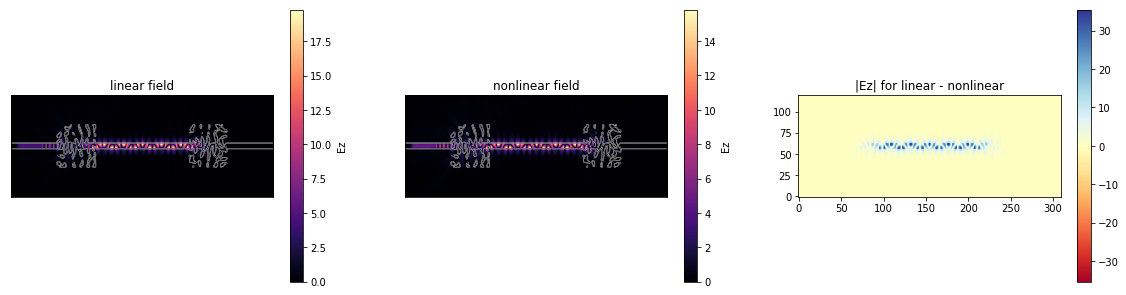

In [149]:
# compare the linear and nonlinear fields

# simulation.eps_r = new_eps

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None)
ax2.set_title('nonlinear field')

# difference
difference = np.abs(Ez.T - Ez_nl.T)
im = plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu', origin='lower')
f.colorbar(im, ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 9.731897517184507e-06


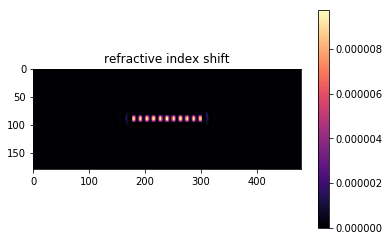

In [147]:
# compute the refractive index shift
index_shift = optimization.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

100% (16 of 16) |########################| Elapsed Time: 0:00:10 ETA:  00:00:00

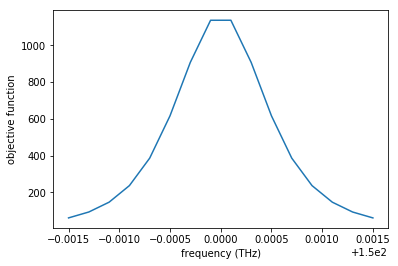

computed FWHM of 0.0011999999998125 (THz):


In [136]:




freqs, objs, FWHM = optimization.scan_frequency(Nf=16, df=1/50000)
optimization.simulation.omega = omega
plt.plot([f/1e12 for f in freqs], objs)
plt.xlabel('frequency (THz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (THz):'.format(FWHM/1e12))


In [146]:
print(np.max(simulation.eps_nl))

4.749175459444886e-05


In [121]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.W_in

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.W_in

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))


difference of 96.70260763105973 %
linear transmission    = 0.5638685243620024
nonlinear transmission = 0.01859295769316875
difference of 54.52755666688337 %
